# Дерево решений — регрессор
Регрессионное дерево делит пространство признаков на области и прогнозирует среднее значение цели внутри каждой области: $\hat{y}(x)=\frac{1}{|R_m|}\sum_{i:x_i\in R_m} y_i$. Разбиения выбираются по минимизации суммы квадратов ошибок, эквивалентной уменьшению дисперсии в узлах: $\min_{s,j}\left[\sum_{i\in R_1(s,j)} (y_i-\bar{y}_{R_1})^2 + \sum_{i\in R_2(s,j)} (y_i-\bar{y}_{R_2})^2\right]$. Глубина и минимальный размер листа контролируют переобучение.


## Используемые библиотеки
Подключаем `numpy`, `pandas` для вычислений и работы с таблицами, `seaborn` и `matplotlib` для графиков, из `sklearn` — загрузчик `load_diabetes`, `train_test_split`, `DecisionTreeRegressor` и регрессионные метрики.


In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [20]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.dpi"] = 120
PRIMARY_COLOR = "#1f77b4"
SECONDARY_COLOR = "#ff7f0e"
HEATMAP_CMAP = "coolwarm"


## Датасет: описание и частичная распечатка
Датасет **Diabetes** из `sklearn` — 442 пациента, 10 нормализованных числовых признаков: возраст, пол, ИМТ, среднее артериальное давление и шесть биохимических показателей крови. Целевая переменная — **target**: количественная мера прогрессирования диабета через год после начала исследования. Задача — регрессия. Датасет небольшой, что делает его удобным для демонстрации склонности дерева к переобучению.


In [21]:
diabetes = load_diabetes(as_frame=True)
data = diabetes.frame
print(f"Размерность: {data.shape}")
data.head()


Размерность: (442, 11)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


## Предварительная обработка
Отделяем признаки от целевой переменной. Разбиваем на train/test (80/20). Деревья инвариантны к масштабу признаков — дополнительная стандартизация не нужна. Фиксируем `random_state=42` для воспроизводимости разбивки.


In [22]:
features = data.drop(columns=["target"])
target = data["target"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)


## Тепловая карта корреляций
Матрица корреляций для 10 признаков и целевой переменной. Видно, что **bmi** (ИМТ) и **s5** (уровень серотонина) наиболее коррелируют с прогрессированием диабета. Некоторые биохимические показатели коррелируют между собой — мультиколлинеарность не влияет на качество дерева, но полезна для интерпретации важности признаков.


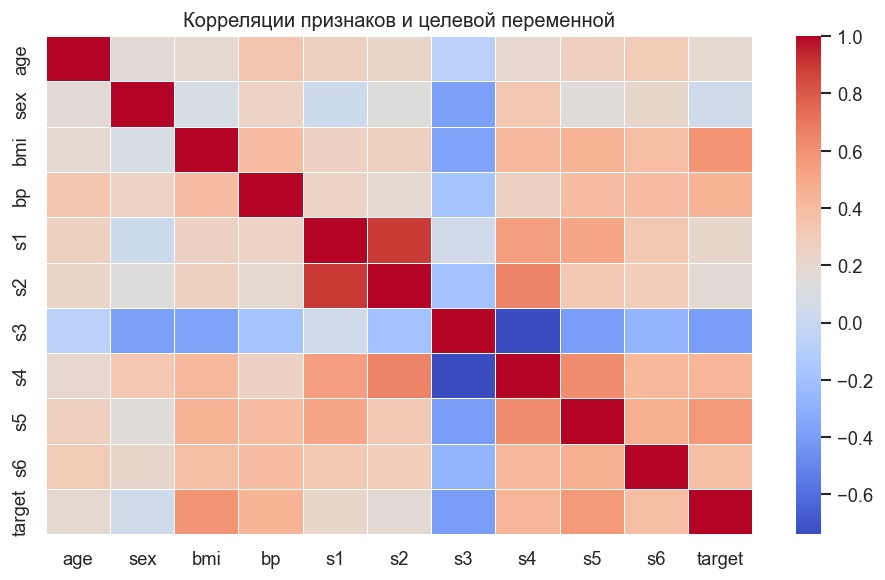

In [23]:
plt.figure(figsize=(8, 5))
correlation = data.corr()
sns.heatmap(correlation, annot=False, cmap=HEATMAP_CMAP, linewidths=0.5)
plt.title("Корреляции признаков и целевой переменной")
plt.tight_layout()
plt.show()


## Обучение модели
Строим `DecisionTreeRegressor` с `max_depth=4`. Ограничение глубины предотвращает полное разбиение обучающих данных (каждый лист = один объект), которое приводит к нулевой ошибке на train, но плохому обобщению. Параметр `random_state` фиксирует случайный выбор признака при одинаковой важности.


In [24]:
model = DecisionTreeRegressor(max_depth=4, random_state=42)
model.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=4, random_state=42)

## Прогнозы модели
Три регрессионные метрики:
- **MAE** — среднее отклонение в единицах целевой переменной;
- **RMSE** — штрафует крупные ошибки сильнее MAE;
- **R²** — 1.0 идеально, значения 0.4–0.6 типичны для дерева с ограниченной глубиной на этом датасете.


In [25]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Decision Tree Regressor Metrics")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.3f}")


Decision Tree Regressor Metrics
MAE:  47.05
RMSE: 59.74
R2:   0.326


## Графики выходных результатов
**График 1. Факт vs Прогноз.** Ступенчатый характер точек — особенность дерева: оно предсказывает конечное число уникальных значений (по одному на лист). Хорошая модель — точки вдоль диагонали.

**График 2. Важность признаков (Feature Importances).** Показывает вклад каждого признака в снижение MSE при разбиениях. **bmi** и **s5** должны лидировать — это соответствует корреляционному анализу.


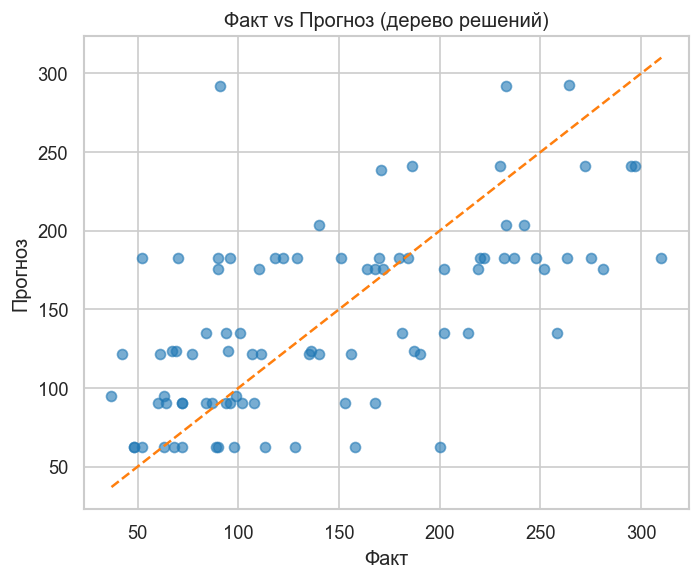

In [26]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color=PRIMARY_COLOR)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color=SECONDARY_COLOR,
    linestyle="--",
)
plt.xlabel("Факт")
plt.ylabel("Прогноз")
plt.title("Факт vs Прогноз (дерево решений)")
plt.tight_layout()
plt.show()


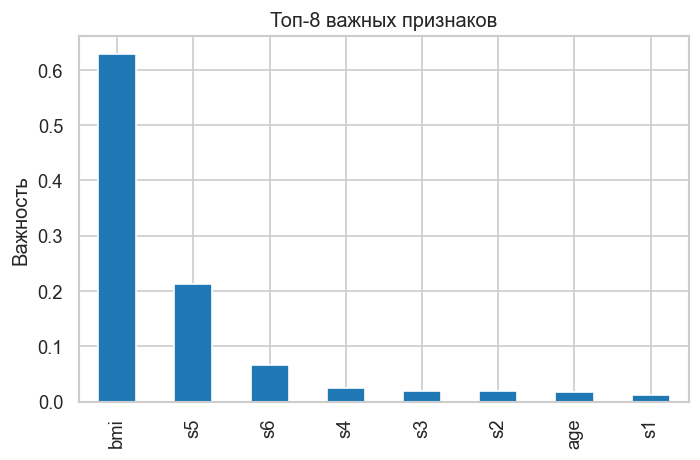

In [27]:
importance = pd.Series(model.feature_importances_, index=features.columns)
importance = importance.sort_values(ascending=False)
plt.figure(figsize=(6, 4))
importance.head(8).plot(kind="bar", color=PRIMARY_COLOR)
plt.ylabel("Важность")
plt.title("Топ-8 важных признаков")
plt.tight_layout()
plt.show()
